In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick
from dftpy.ions import Ions
from dftpy.formats import io
from dftpy.constants import Units
from dftpy.td.utils import calc_spectra_mu

In [14]:
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [1, 2, 1]
atoms = FaceCenteredCubic('Ag', surfaces, layers)

In [15]:
atoms.set_cell([10,10,10])

In [16]:
atoms.cell

Cell([10.0, 10.0, 10.0])

In [42]:
atoms.wrap()
atoms.center(vacuum=10.0)

In [57]:
atoms.cell

Cell([24.089999999999996, 24.089999999999996, 24.089999999999996])

In [43]:
import py3Dmol
from ase.build import bulk
from ase.io import write
from ase.constraints import FixBondLength
c = FixBondLength(0, 10)
atoms.set_constraint(c)
write('cluster.xyz',atoms)
v = py3Dmol.view(data=open('./cluster.xyz','r').read(), style='sphere',linked=False)
v.addUnitCell()
v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [44]:
ions = Ions.from_ase(atoms)

In [45]:
PP_list = ['./OEPP/OEPP/UPF/Ag_OEPP_PZ.UPF']
grid = DirectGrid(ions.cell, spacing = 1.1)

In [46]:
ke = Functional(type='KEDF',name='TFvW')
xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list)
totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)

setting key: Ag -> ./OEPP/OEPP/UPF/Ag_OEPP_PZ.UPF


In [47]:
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

In [48]:
optimization_options = {'econv' : 1e-9,'maxiter' : 100}

opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')

In [49]:
 rho0 = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.491892512135E+00      5.491893E+00    8.282699E-01    1       1       6.154013E-02    
!WARN: Change to steepest decent
1       -1.771792280812E+00     -7.263685E+00   8.279394E-01    1       4       1.699202E-01    
2       -2.431713896451E+00     -6.599216E-01   1.390363E-01    6       2       3.210745E-01    
3       -2.510891474623E+00     -7.917758E-02   1.626424E-02    5       1       4.378014E-01    
4       -2.533807311693E+00     -2.291584E-02   3.405001E-03    10      1       6.385415E-01    
5       -2.537861926341E+00     -4.054615E-03   4.825607E-04    9       2       8.432808E-01    
6       -2.538484118133E+00     -6.221918E-04   6.024819E-05    10      2       1.066237E+00    
7       -2.538544335327E+00     -6.021719E-05   8.430590E-06    9       2       1.270681E+00    
8       -2.538551190213E+00     -6.854886E-06   1.023050E-06    10      1       1.473479E+00  

In [50]:
 ke.options.update({'y':0})

In [51]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively
k = 1.0e-3 # kick_strength in a.u.
interval = 0.04 

In [52]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        print("\r", end="")
        print(f"Progress: [{self.nsteps+1}/{self.max_steps}]", "|" * (self.nsteps*50 // self.max_steps), end="", flush=True)

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [58]:
max_steps = 1000
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

Progress: [1000/1000] |||||||||||||||||||||||||||||||||||||||||||||||||

False

In [59]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
mu = np.asarray(runner.dipole)

Text(0, 0.5, 'Dipole Moment (au)')

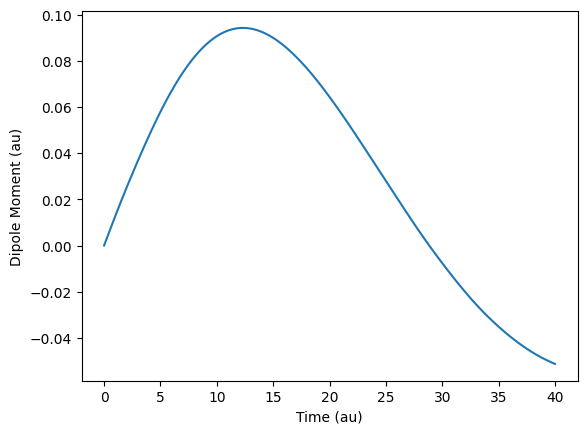

In [60]:
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

(0.0, 40.0)

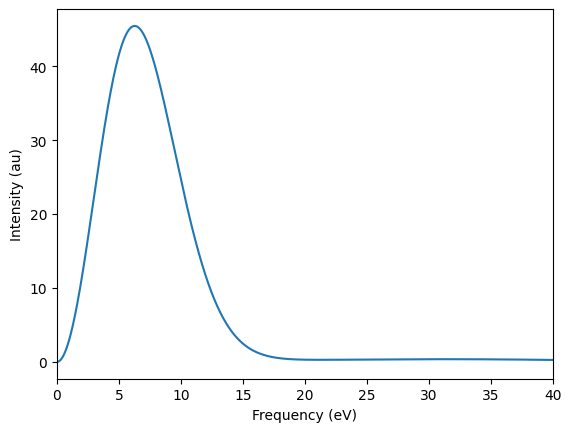

In [62]:
omega, spectra = calc_spectra_mu(delta_mu, interval, kick=k, sigma=0.01)
plt.plot(omega*Units.Ha, spectra, '-')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 40)